# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [50]:
BATCHES_DIR = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/11/logs-rasp3-3dic2018/batch-test-report'
TEST_CONFIG_FILE = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/11/logs-rasp3-3dic2018/description.yml'
NET_USAGE_FILE='/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/11/logs-rasp3-3dic2018/network_usage.log'
NET_USAGE_SEPARATOR='|'

In [51]:
# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import time

from processor import analysis, reports

from IPython.display import display

base_directory = BATCHES_DIR
with open(TEST_CONFIG_FILE) as fp:
    batch_description = yaml.load(fp)
batch_description

{'intervals': [{'duration_minutes': 60, 'speed_percentage': 0},
  {'duration_minutes': 60, 'speed_percentage': 25},
  {'duration_minutes': 60, 'speed_percentage': 50},
  {'duration_minutes': 60, 'speed_percentage': 75},
  {'duration_minutes': 60, 'speed_percentage': 100},
  {'duration_minutes': 60, 'speed_percentage': 0}],
 'max_speed_kbps': 30000,
 'network_interface': 'wlan0',
 'start_time': 1543816800.106578}

In [52]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    
    test_start_epoch = batch_description['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in batch_description['intervals']:
        lapse = experiment_configuration['duration_minutes'] * 60
        start = experiment_start_epoch
        end = experiment_start_epoch + lapse
        
        if start <= batch_start_time < end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = start
        if start <= batch_end_time < end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = end
        
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        # TODO actualizar esta parte con el nuevo yml
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    return expected_usage
    

In [53]:
net_usage_time = []
net_usage_speed = []
with open(NET_USAGE_FILE) as net_usage_file:
  # Skip header
  next(net_usage_file)
  for line in net_usage_file:
    (epoch, speed) = line.split(NET_USAGE_SEPARATOR)
    usage_time =  datetime.datetime.fromtimestamp(float(epoch))
    # TODO verify the units in which the speed comes. 
    # By dividing over 1024*64, we get it to match the other plots in kbps.
    speed_kbps = int(speed) / (1024.0 * 64.0)
    # Skip odd negative values which break the plot.
    if speed_kbps >= 0:
      net_usage_time.append(usage_time)
      net_usage_speed.append(speed_kbps)

In [54]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1543816871,1543817865,2018-12-03 03:01:11,2018-12-03 03:17:45,0.459623,0.325810,1.0,0.154023,0.486763,0.462258,1.0,0.528067,0.000000,0.154023,0.154023
1,1543817419,1543818381,2018-12-03 03:10:19,2018-12-03 03:26:21,0.551640,0.291135,1.0,0.108046,0.514533,0.483957,1.0,0.561243,0.000000,0.108046,0.108046
2,1543817968,1543818856,2018-12-03 03:19:28,2018-12-03 03:34:16,0.457383,0.246038,1.0,0.176329,0.534673,0.637889,1.0,0.513889,0.000000,0.176329,0.176329
3,1543818517,1543819261,2018-12-03 03:28:37,2018-12-03 03:41:01,0.538840,0.545291,1.0,0.082789,0.555675,0.476737,1.0,0.555957,0.000000,0.082789,0.082789
4,1543819066,1543820011,2018-12-03 03:37:46,2018-12-03 03:53:31,0.531469,0.386954,1.0,0.083141,0.541325,0.550245,1.0,0.521654,0.000000,0.083141,0.083141
5,1543819615,1543820601,2018-12-03 03:46:55,2018-12-03 04:03:21,0.550248,0.466772,1.0,0.271137,0.501499,0.211517,1.0,0.672055,0.050936,0.220201,4.323044
6,1543820164,1543821113,2018-12-03 03:56:04,2018-12-03 04:11:53,0.506773,0.565158,1.0,0.513699,0.505432,0.437911,1.0,0.610294,0.187801,0.325897,1.735332
7,1543820776,1543821531,2018-12-03 04:06:16,2018-12-03 04:18:51,0.585878,0.639204,1.0,0.545872,0.528517,0.326186,1.0,0.617849,0.250000,0.295872,1.183486
8,1543821328,1543821832,2018-12-03 04:15:28,2018-12-03 04:23:52,0.487424,0.795250,1.0,0.492683,0.536720,0.471579,1.0,0.594650,0.250000,0.242683,0.970732
9,1543821880,1543822591,2018-12-03 04:24:40,2018-12-03 04:36:31,0.501693,0.291879,1.0,0.489669,0.556305,0.496279,1.0,0.647917,0.250000,0.239669,0.958678


<IPython.core.display.Javascript object>


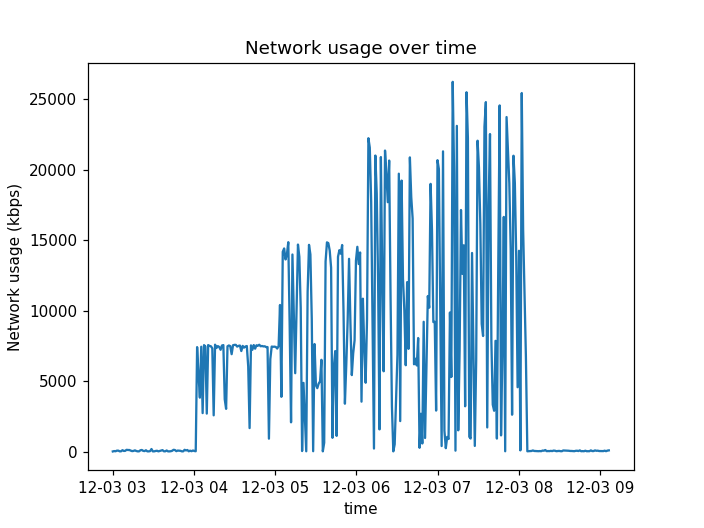

In [55]:
plt.figure()
plt.plot(net_usage_time, net_usage_speed)
plt.xlabel('time')
plt.ylabel('Network usage (kbps)')
plt.title('Network usage over time')
plt.show()

<IPython.core.display.Javascript object>


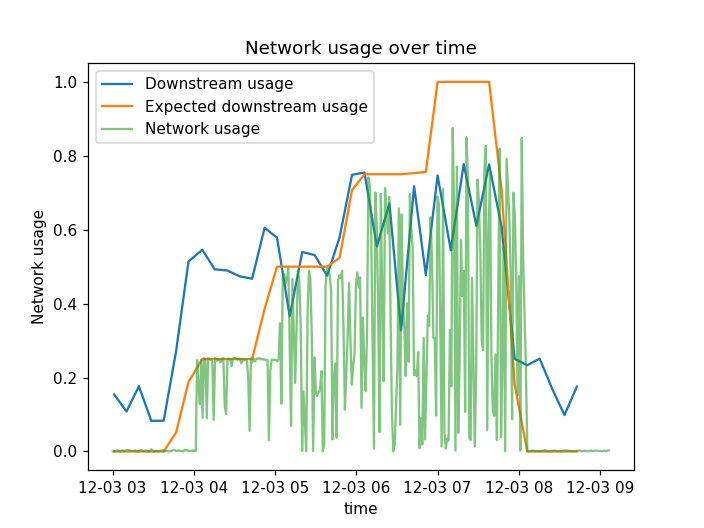

In [47]:
normalized_net_usage = [speed_kbps / batch_description['max_speed_kbps'] for speed_kbps in net_usage_speed]
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.plot(net_usage_time, normalized_net_usage, alpha=0.6)
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Network usage over time')
plt.legend(['Downstream usage', 'Expected downstream usage', 'Network usage'])
plt.show()

# data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')

In [30]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,39.000000,39.000000
mean,0.144362,0.208978
std,0.111985,0.197886
min,0.002418,0.012436
25%,0.043777,0.073496
50%,0.116223,0.136264
75%,0.207724,0.276294
max,0.395010,0.901524


<IPython.core.display.Javascript object>


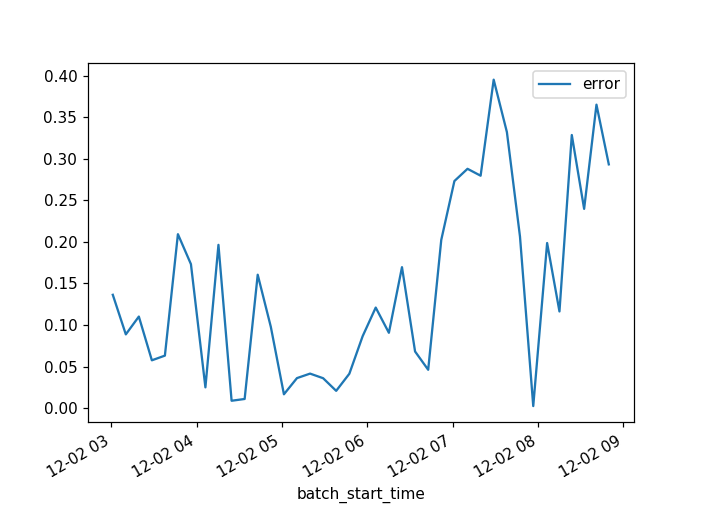

In [31]:
data.plot(x='batch_start_time', y='error', kind='line')

<IPython.core.display.Javascript object>


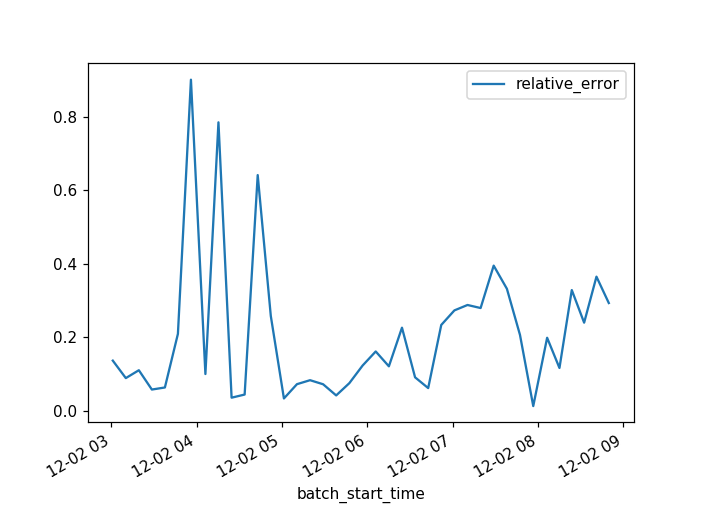

In [32]:
data.plot(x='batch_start_time', y='relative_error', kind='line')